# Imports

In [113]:
!pip install pydub

17622.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [114]:
import os
from os import listdir
from pathlib import Path

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile
from os.path import isdir, join

import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from tqdm import tqdm

import tensorflow_datasets as tfds

from pydub import AudioSegment
from pydub.playback import play
import soundfile as sf

import typing as T

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.17.0


# Download the dataset

In [115]:
ds, info = tfds.load('speech_commands',
                     split=['train', 'validation'], 
                     data_dir='dataset', 
                     with_info=True)

## Extract the dataset

In [116]:
!tar -xzf "dataset/downloads/down.tens.org_spee_comm_test_set_v0.2zCoAwRR8IlTpvj-g93nYwXQh3DSbhjZlZ6jt-prNUd8.tar.gz" -C "dataset/downloads/extracted"
!tar -xzf "dataset/downloads/down.tens.org_spee_comm_test_set_v0.2zCoAwRR8IlTpvj-g93nYwXQh3DSbhjZlZ6jt-prNUd8.tar.gz.INFO" -C "dataset/downloads/extracted"
!tar -xzf "dataset/downloads/downloa.tensorf.org_speech_command_v0.2rxRznufcMRRx3pj1-dLJGRsYrt_pV_Sm_3kccJho_1g.tar.gz" -C "dataset/downloads/extracted"
!tar -xzf "dataset/downloads/downloa.tensorf.org_speech_command_v0.2rxRznufcMRRx3pj1-dLJGRsYrt_pV_Sm_3kccJho_1g.tar.gz.INFO" -C "dataset/downloads/extracted"

17629.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
17636.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


tar: Error opening archive: Unrecognized archive format


17642.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
17681.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


tar: Error opening archive: Unrecognized archive format


## Split the background_noise files into 1 second wav files, because they are longer than 1 second each.

In [117]:
background_noise_base_dir = "dataset/downloads/extracted/_background_noise_"
background_noise_path = Path(background_noise_base_dir).rglob("*.wav")

for background_noise_audio in background_noise_path:
  # Load the file

  file_name = background_noise_audio.stem
  audio, sr = librosa.load(background_noise_audio, sr=None)

  # Split the file by second

  for i in range(int(len(audio)/sr)):
    sf.write(f"{background_noise_base_dir}/{file_name}_{i}.wav", audio[(i*sr):(i+1)*sr], sr)

  # Remove the original file since it is not useful anymore

  os.system(f"rm {background_noise_audio}")

# Create dataset

In [ ]:
dataset_path = 'dataset/downloads/extracted'

In [ ]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]

# Sort the files because `listdir` always changes the order of listed files

all_targets.sort()

print(all_targets)

['_background_noise_', '_silence_', '_unknown_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [ ]:
# Settings

target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
sample_rate = 16000 # Hz
num_mfcc = 16

# number of frames
len_mfcc = 28

In [ ]:
# Check the total number of files

num_samples = 0
for target in all_targets:
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

Total samples: 108296


In [ ]:
# Create list of filenames along with ground truth vector (y)

filenames = []
y = []

for index, target in enumerate(target_list):
    print(join(dataset_path, target), ", index ", index)
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

dataset/downloads/extracted/_background_noise_ , index  0
dataset/downloads/extracted/_silence_ , index  1
dataset/downloads/extracted/_unknown_ , index  2
dataset/downloads/extracted/backward , index  3
dataset/downloads/extracted/bed , index  4
dataset/downloads/extracted/bird , index  5
dataset/downloads/extracted/cat , index  6
dataset/downloads/extracted/dog , index  7
dataset/downloads/extracted/down , index  8
dataset/downloads/extracted/eight , index  9
dataset/downloads/extracted/five , index  10
dataset/downloads/extracted/follow , index  11
dataset/downloads/extracted/forward , index  12
dataset/downloads/extracted/four , index  13
dataset/downloads/extracted/go , index  14
dataset/downloads/extracted/happy , index  15
dataset/downloads/extracted/house , index  16
dataset/downloads/extracted/learn , index  17
dataset/downloads/extracted/left , index  18
dataset/downloads/extracted/marvin , index  19
dataset/downloads/extracted/nine , index  20
dataset/downloads/extracted/no 

In [ ]:
# Check how filenames are stored

print(filenames[0:5])

[['running_tap_34_0.wav', 'doing_the_dishes_86_0_0_0_0_0_0.wav', 'running_tap_17_0_0.wav', 'white_noise_10.wav', 'pink_noise_26.wav', 'dude_miaowing_54_0_0_0_0.wav', 'doing_the_dishes_20_0_0_0_0_0_0.wav', 'running_tap_42_0_0_0_0_0_0.wav', 'dude_miaowing_21_0_0_0_0_0_0.wav', 'exercise_bike_48_0.wav', 'doing_the_dishes_85_0_0.wav', 'pink_noise_32.wav', 'white_noise_38.wav', 'exercise_bike_17_0_0_0_0_0_0.wav', 'exercise_bike_8_0_0_0_0.wav', 'white_noise_9_0_0_0_0.wav', 'white_noise_3_0_0_0_0_0_0.wav', 'white_noise_15_0_0.wav', 'dude_miaowing_24_0_0_0_0.wav', 'running_tap_23.wav', 'pink_noise_57_0_0.wav', 'exercise_bike_11_0_0.wav', 'white_noise_16_0_0_0_0.wav', 'running_tap_37.wav', 'pink_noise_47_0_0.wav', 'white_noise_48_0_0_0_0.wav', 'exercise_bike_15_0_0_0_0.wav', 'doing_the_dishes_13_0_0_0_0.wav', 'pink_noise_35_0_0.wav', 'dude_miaowing_54_0.wav', 'pink_noise_25_0_0.wav', 'doing_the_dishes_66.wav', 'pink_noise_27_0_0_0_0_0_0.wav', 'running_tap_57_0_0_0_0.wav', 'pink_noise_27_0_0_0_0.

In [ ]:
# Check ground truth Y vector

print(y)

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [ ]:
# Flatten filename and y vectors

filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [ ]:
filenames[0:5]

['running_tap_34_0.wav',
 'doing_the_dishes_86_0_0_0_0_0_0.wav',
 'running_tap_17_0_0.wav',
 'white_noise_10.wav',
 'pink_noise_26.wav']

In [ ]:
y[0:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

## Create variables for C files

In [ ]:
# Generate the dictionary

for target in all_targets:
  print(target.upper(), end = ",")

_BACKGROUND_NOISE_,_SILENCE_,_UNKNOWN_,BACKWARD,BED,BIRD,CAT,DOG,DOWN,EIGHT,FIVE,FOLLOW,FORWARD,FOUR,GO,HAPPY,HOUSE,LEARN,LEFT,MARVIN,NINE,NO,OFF,ON,ONE,RIGHT,SEVEN,SHEILA,SIX,STOP,THREE,TREE,TWO,UP,VISUAL,WOW,YES,ZERO,

In [ ]:
# Create extern constants

for w in all_targets:
  print(f"extern const char {w.upper()}[];")

extern const char _BACKGROUND_NOISE_[];
extern const char _SILENCE_[];
extern const char _UNKNOWN_[];
extern const char BACKWARD[];
extern const char BED[];
extern const char BIRD[];
extern const char CAT[];
extern const char DOG[];
extern const char DOWN[];
extern const char EIGHT[];
extern const char FIVE[];
extern const char FOLLOW[];
extern const char FORWARD[];
extern const char FOUR[];
extern const char GO[];
extern const char HAPPY[];
extern const char HOUSE[];
extern const char LEARN[];
extern const char LEFT[];
extern const char MARVIN[];
extern const char NINE[];
extern const char NO[];
extern const char OFF[];
extern const char ON[];
extern const char ONE[];
extern const char RIGHT[];
extern const char SEVEN[];
extern const char SHEILA[];
extern const char SIX[];
extern const char STOP[];
extern const char THREE[];
extern const char TREE[];
extern const char TWO[];
extern const char UP[];
extern const char VISUAL[];
extern const char WOW[];
extern const char YES[];
extern co

In [ ]:
# Create constant strings

for w in all_targets:
  print(f"const char {w.upper()}[] = \"{w}\";")

const char _BACKGROUND_NOISE_[] = "_background_noise_";
const char _SILENCE_[] = "_silence_";
const char _UNKNOWN_[] = "_unknown_";
const char BACKWARD[] = "backward";
const char BED[] = "bed";
const char BIRD[] = "bird";
const char CAT[] = "cat";
const char DOG[] = "dog";
const char DOWN[] = "down";
const char EIGHT[] = "eight";
const char FIVE[] = "five";
const char FOLLOW[] = "follow";
const char FORWARD[] = "forward";
const char FOUR[] = "four";
const char GO[] = "go";
const char HAPPY[] = "happy";
const char HOUSE[] = "house";
const char LEARN[] = "learn";
const char LEFT[] = "left";
const char MARVIN[] = "marvin";
const char NINE[] = "nine";
const char NO[] = "no";
const char OFF[] = "off";
const char ON[] = "on";
const char ONE[] = "one";
const char RIGHT[] = "right";
const char SEVEN[] = "seven";
const char SHEILA[] = "sheila";
const char SIX[] = "six";
const char STOP[] = "stop";
const char THREE[] = "three";
const char TREE[] = "tree";
const char TWO[] = "two";
const char UP[

## Training, validation and test splits

In [ ]:
# Associate filenames with true output and shuffle

filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [ ]:
# Validation and test percentage

val_ratio = 0.1
test_ratio = 0.1

In [ ]:
# Calculate validation and test set sizes

val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)
print(f"Validation size {val_set_size}\ntTest set size {test_set_size}")

Validation size 10829
tTest set size 10829


In [ ]:
# Break dataset apart into train, validation, and test sets

filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [ ]:
# Break y apart into train, validation, and test sets

y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [ ]:
def calc_mfcc(path: str, debug: bool = False) -> np.ndarray:
  """Creates a matrix of MFCCs from the given input file.
  
  Args:
    path: the path to the file to extract MFCCs from
    debug: whenever to print signal shape or sampling rate

  Returns:
    An ndarray of shape (n_mffc, n_frames)
  """

  signal, fs = librosa.load(path, sr=sample_rate)
  if debug:
    print(f"DEBUG (calc_mfcc): signal shape={signal.shape}, sampling rate={fs}")

  # By default, n_fft=2048, hop_length=512
  mfccs = librosa.feature.mfcc(signal, 
                               sr=fs, 
                               n_mfcc=num_mfcc, 
                               dct_type=2, 
                               norm='ortho', 
                               lifter=0, 
                               center=False)
  
  return mfccs

In [ ]:
# TEST: Construct test set by computing MFCC of each WAV file

prob_cnt = 0
x_test = []
y_test = []
max_index_ = 100

for index, filename in enumerate(filenames_train):

    # Stop after `max_index_` iteration
    if index >= max_index_:
        break
    
    # Create path from given filename and target item
    def calc_mfcc(path, debug=False):
        """Creates a matrix of MFCCs from the given input file.
      
        Args:
            path: the path to the file to extract MFCCs from
            debug: whether to print signal shape or sampling rate

        Returns:
            An ndarray of shape (n_mffc, n_frames)
        """

        signal, fs = librosa.load(path, sr=sample_rate)
        if debug:
            print(f"DEBUG (calc_mfcc): signal shape={signal.shape}, sampling rate={fs}")

        # By default, n_fft=2048, hop_length=512
        # mfccs = librosa.feature.mfcc(signal, 
        #                              sr=fs, 
        #                              n_mfcc=num_mfcc, 
        #                              dct_type=2, 
        #                              norm='ortho', 
        #                              lifter=0, 
        #                              center=False)
        mfccs = librosa.feature.mfcc(y=signal,
                                      sr=fs, 
                                      S=None,
                                      n_mfcc=num_mfcc, 
                                      dct_type=2, 
                                      norm='ortho', 
                                      lifter=0, 
                                      center=False)
        return mfccs


In [ ]:
print('% of problematic samples:', prob_cnt / max_index_)

% of problematic samples: 0.0


DEBUG (calc_mfcc): signal shape=(16000,), sampling rate=16000
MFCCs: [[-5.39363708e+02 -5.39439331e+02 -5.39626709e+02 -4.96961761e+02
  -3.81122620e+02 -3.70465210e+02 -4.46093140e+02 -5.23887695e+02
  -5.08169800e+02 -3.73457581e+02 -3.02338898e+02 -2.88350220e+02
  -2.28390305e+02 -1.20707474e+02 -9.03266068e+01 -9.30848923e+01
  -9.95658875e+01 -1.35467896e+02 -1.64258575e+02 -1.84304337e+02
  -1.99667526e+02 -2.19010788e+02 -2.41386734e+02 -2.71957184e+02
  -3.24366669e+02 -3.49694305e+02 -3.69385864e+02 -4.23118805e+02]
 [ 3.59732509e-01  2.56295204e-01  0.00000000e+00 -3.20824203e+01
  -7.70745316e+01 -7.83104095e+01 -4.25118866e+01 -1.12731924e+01
  -2.73637657e+01  7.50822067e+01  1.22784180e+02  1.59143173e+02
   1.85712601e+02  1.64403976e+02  1.48854370e+02  1.44401733e+02
   1.84578186e+02  2.31784866e+02  2.44518936e+02  2.29546783e+02
   2.11406982e+02  1.91632385e+02  1.84416962e+02  1.86700012e+02
   1.70433594e+02  1.48625244e+02  1.26662704e+02  8.83829117e+01]
 [ 3.

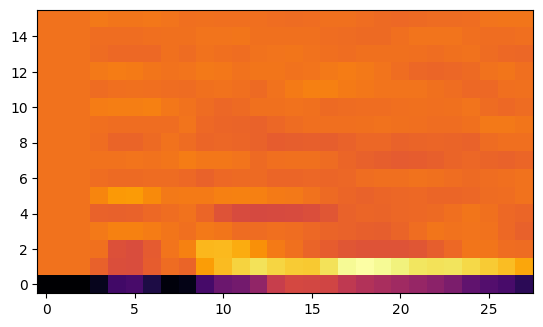

In [ ]:
# TEST: Test shorter MFCC

idx = 41

# Create path from given filename and target item
path = join(dataset_path, 
            target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path, debug=True)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# Play wav file
print(target_list[int(y_orig_train[idx])])
AudioSegment.from_file(path, format="wav")

In [ ]:
def to_word(out_value):
    """Converts the outuput value of the model to the corresponding word."""

    return target_list[int(out_value)]

In [ ]:
def extract_features(in_files: T.List[str], 
                     in_y: T.List[float]) -> T.List[np.ndarray]:
    """Computes a dataset of MFCC from the given input files, and associate them
    with the ground truth values.
    
    If the size of sample frames is less than the target one, then the sample 
    will be discarded.

    Args:
      in_files: list of wav files
      in_y: the ground truth values of the files in `in_files`

    Returns:
      A list of np.ndarray containing the MFCCs extracted from `in_files`
    """

    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in tqdm(enumerate(in_files), total=len(in_files)):
      
        # Create path from given filename and target item
        path = join(dataset_path,
                    target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with the correct number of frames
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else: 
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [ ]:
# Create train, validation, and test sets

x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))

x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))

x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

  0%|          | 1/86638 [00:00<4:11:18,  5.75it/s]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 86638/86638 [24:19<00:00, 59.35it/s]  


Removed percentage: 0.09610101802904038


100%|██████████| 10829/10829 [02:47<00:00, 64.73it/s] 


Removed percentage: 0.09853172038045988


100%|██████████| 10829/10829 [02:27<00:00, 73.27it/s]

Removed percentage: 0.0952996583248684


In [ ]:
# Save features and truth vector (y) sets to disk

np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

# Create the model

## Load dataset back

In [ ]:
# Load features

feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [ ]:
# Assign feature sets

x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [ ]:
# Concatenate training and validation sets, since they will be splitted in
# stratified manner in the next steps

X = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (88073, 16, 28), y shape: (88073,)


In [ ]:
# Number of unique labels. When the whole dataset is loaded, it should be 38.

n_labels = np.max([len(np.unique(y_test)), 
                   len(np.unique(y))])

n_labels

38

In [ ]:
# Settings

model_filename = 'speech-commands-model.h5'
keras_model_filename = 'speech-commands-model.h5'
tflite_filename = 'speech-commands-model.tflite'

In [ ]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1

x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)

X = X.reshape(X.shape[0], 
              X.shape[1], 
              X.shape[2], 
              1)

print(x_test.shape)
print(X.shape)

(9797, 16, 28, 1)
(88073, 16, 28, 1)


In [ ]:
# Input shape for CNN is size of MFCC of 1 sample

input_shape = X.shape[1:]
print(input_shape)

(16, 28, 1)


## Define the model

In [ ]:
from tensorflow.keras import layers, models, regularizers

In [ ]:
def create_model(verbose: int =0):
  """Creates and build a CNN model.

  Args:
    verbose: the verbosity of the output

  Returns:
    the CNN model already complied.
  """
  # build network
  model = models.Sequential()

  # conv layer 1
  model.add(layers.Conv2D(8,
                          (3, 3), 
                          activation="relu", 
                          input_shape=input_shape))
  # conv layer 2
  model.add(layers.Conv2D(8,
                          (3, 3), 
                          activation="relu"))
  model.add(layers.MaxPool2D((2,2)))
  model.add(layers.Dropout(0.1))

  model.add(layers.Flatten())

  model.add(layers.Dense(64))
  model.add(layers.Dropout(0.16))
  model.add(layers.Activation("relu"))

  model.add(layers.Dense(64))
  model.add(layers.Dropout(0.12))
  model.add(layers.Activation("relu"))

  #softmax classifier
  model.add(layers.Dense(n_labels))
  model.add(layers.Activation("softmax"))

  #compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(), 
      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
      metrics=["accuracy"],
  ) 

  if verbose > 0:
    model.summary()

  return model

## Cross Validation

In [ ]:
def cross_validate(
    model_fn: T.Callable[[int], models.Model], 
    X: np.ndarray, 
    y: np.ndarray,
    n_splits: int = 5,
    batch_size: int = 100,
    epochs: int = 40,
    verbose: int = 0,
) -> T.Tuple[T.List[float], T.List[T.Dict]]:
  """Computes the cross validation of the input model.

  By default, it will split the input dataset in a stratified manner.

  `model_fn` should be a function that returns a keras Model, with a single 
  input parameter which specifies the verbosity.

  Args:
    model_fn: a function to create a Keras model
    X: training set
    y: labels for the training set
    n_splits: the number of folds for the stratified cross validation
    batch_size: the size of the batch during training
    epochs: the number of epochs to train the model
    verbose: the levl of verbosity

  Returns:
    A tuple with values (accuracy scores, metric histories) obtained during the
    different trainings in the folds.
  """
  
  # Hold the history of each model trained during different folds
  histories = []

  # Maximum accuracy scored during the training in each fold
  accuracy_scores = []

  # Prevent multiple printing of the model summary
  print_model = 1

  # Stratified splitter
  skf = StratifiedKFold(n_splits=n_splits)

  for fold, (train_idx, test_idx) in tqdm(
      enumerate(skf.split(X, y)), 
      total=skf.get_n_splits(),
  ):

    # Get training and test sets from the split
    X_train_, X_test_ = X[train_idx], X[test_idx]
    y_train_, y_test_ = y[train_idx], y[test_idx]

    # Create a fresh model
    model = model_fn(print_model)
    
    print_model=0

    # Train the model

    history = model.fit(X_train_,
                        y_train_,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test_, y_test_),
                        verbose=verbose,
                        callbacks=[tf.keras.callbacks.EarlyStopping(
                          monitor='val_accuracy',
                          patience=5,
                          min_delta=0.001,
                          mode='max',
                          restore_best_weights=True
                        )])


    # Save metrics 

    histories.append(history.history)
    accuracy_scores.append(np.max(history.history['val_accuracy']))
    print(f"Max validation accuracy for fold {fold}: "
          f"{np.max(history.history['val_accuracy'])}")

  return (accuracy_scores, histories)


In [ ]:
def plot_metrics(history: T.Dict):
  """Plots the training history.

  The input should be the dictionary inside the History object returned by the 
  fit method of Tensorflow.

  Args: 
    history: dictionary of the history metrics of the trained model

  Returns:
    None
  """
  
  acc = history['accuracy']
  loss = history['loss']
  val_acc = history['val_accuracy']
  val_loss = history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
# Cross validate the model

acc, hist = cross_validate(create_model, 
                           X,
                           y,
                           epochs=100, 
                           verbose=0)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/klaashofman/Development/Rimshot/sandbox/stm32/stm32-speech-recognition-and-traduction/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 24, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 12, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 12, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         2,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 38)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,222 (172.74 KB)

 Trainable params: 44,222 (172.74 KB)

 Non-trainable params: 0 (0.00 B)

 20%|██        | 1/5 [02:41<10:45, 161.48s/it]

Max validation accuracy for fold 0: 0.7775759100914001


 40%|████      | 2/5 [05:28<08:13, 164.56s/it]

Max validation accuracy for fold 1: 0.7921090126037598


 60%|██████    | 3/5 [10:35<07:39, 229.78s/it]

Max validation accuracy for fold 2: 0.7436276078224182


 80%|████████  | 4/5 [15:18<04:10, 250.67s/it]

Max validation accuracy for fold 3: 0.7841489911079407


100%|██████████| 5/5 [20:16<00:00, 243.20s/it]

Max validation accuracy for fold 4: 0.789939820766449


Mean accuracy: 0.7774802684783936, Max accuracy: 0.7921090126037598


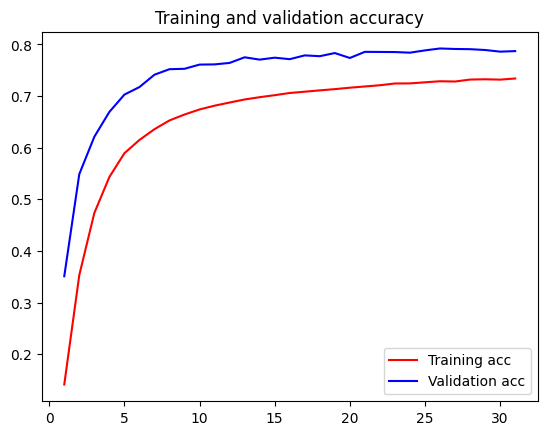

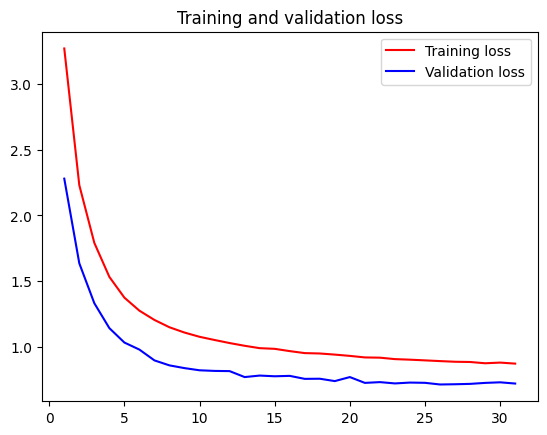

In [ ]:
mean = np.mean(acc)
max = np.max(acc)
max_idx = np.argmax(acc)
print(f"Mean accuracy: {mean}, Max accuracy: {max}")
plot_metrics(hist[max_idx])

## Train the model

In [ ]:
epochs = 100
batch_size = 100

# Store all the trained models
all_model = []

model = create_model()

history = model.fit(X, 
                    y, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='accuracy',
                        patience=5,
                        min_delta=0.001,
                        mode='max',
                        restore_best_weights=True
                    )])

Epoch 1/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0809 - loss: 4.0282
Epoch 2/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3100 - loss: 2.4192
Epoch 3/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4494 - loss: 1.8968
Epoch 4/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5119 - loss: 1.6550
Epoch 5/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5619 - loss: 1.4737
Epoch 6/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5889 - loss: 1.3708
Epoch 7/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6110 - loss: 1.2908
Epoch 8/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6315 - loss: 1.2316
Epoch 9/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6401 - loss: 1.1929
Epoch 10/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6578 - loss: 1.1449
Epoch 11/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6579 - loss: 1.1274
Epoch 12/100
881/881 ━━━━━━━━━━━━━━━━━━━━

# Model Evaluation

In [ ]:
def plot_confusion_matrix(
    model, 
    X: np.ndarray, 
    y_true: np.ndarray, 
    labels: T.Union[str, T.List[str]] ="auto"):
  
  """Computes the confusion matrix of the input model.
  
  Args:
    model: the model on which confusion matrix will be computed
    X: dataset to evalutate the model
    y_true: ground truth values of the dataset
    labels: the labels to use in the plot of the confusion matrix
    
  Returns:
    None
  """

  confusion_matrix = tf.math.confusion_matrix(
      y_true, 
      np.argmax(model.predict(X), axis=1),
  )

  plt.figure(figsize=(15,15))
  sbn.heatmap(confusion_matrix, 
              cmap='Greens', 
              xticklabels=labels, 
              yticklabels=labels)
  plt.xlabel("Prediction")
  plt.ylabel("Label")
  plt.show()

2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


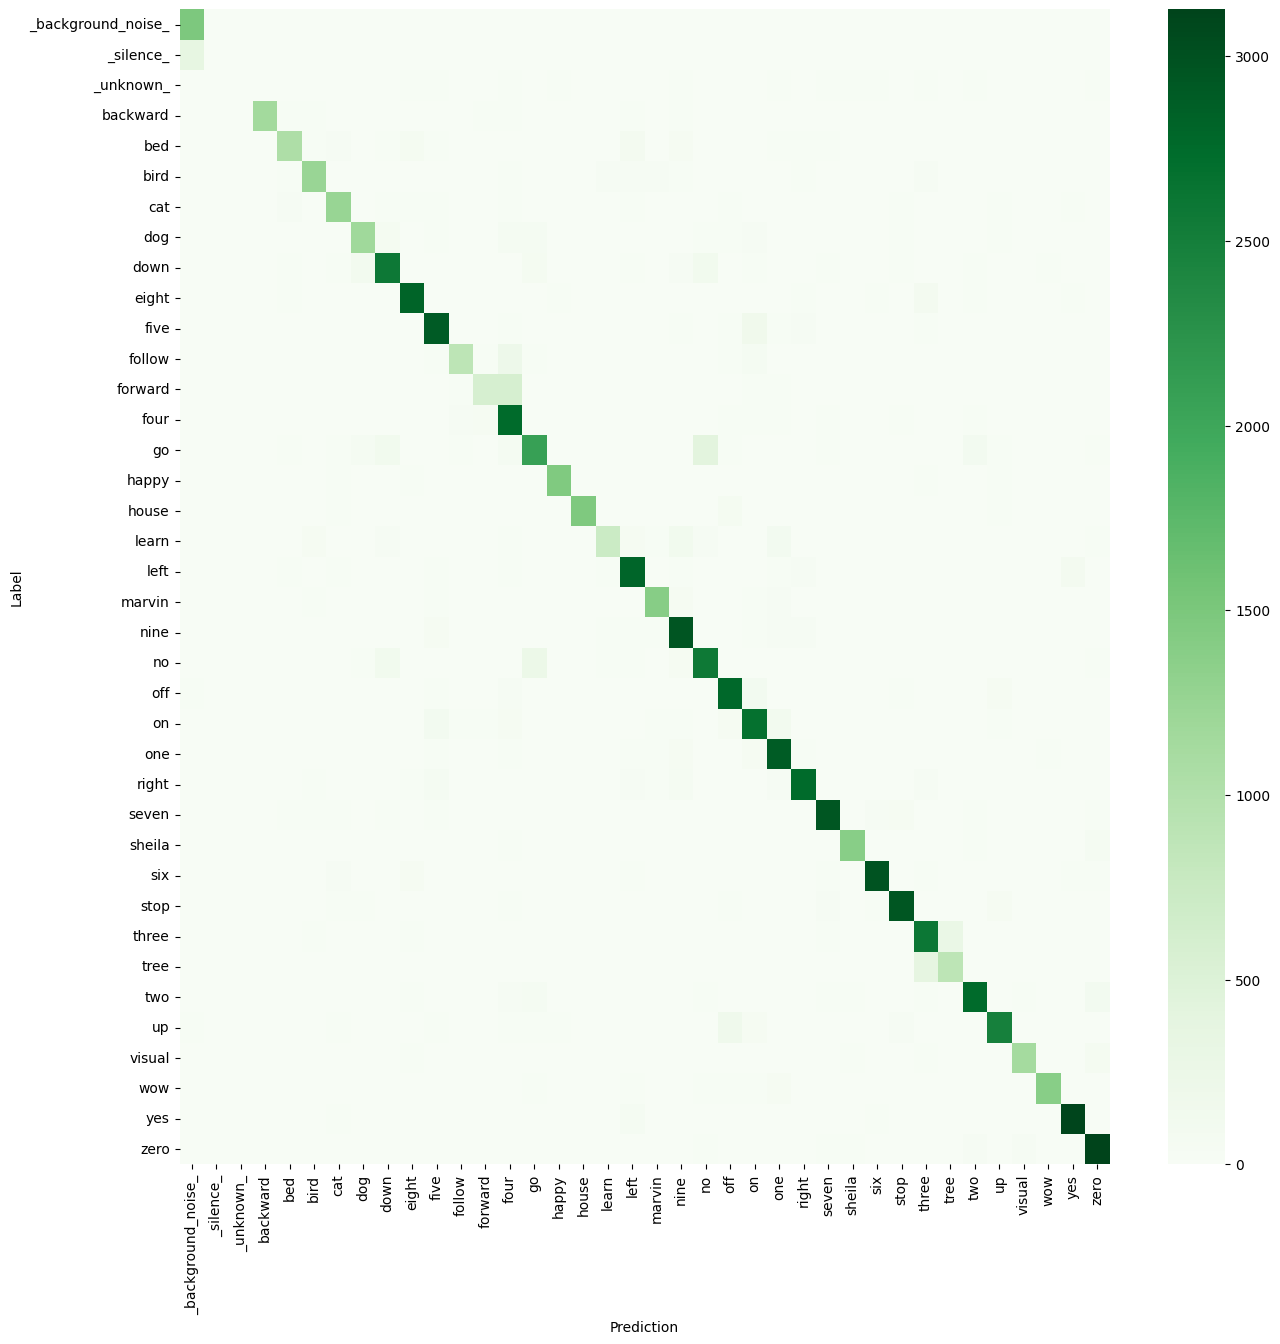

In [ ]:
plot_confusion_matrix(model, X, y, labels=target_list)

In [ ]:
# Evalute test set performance

model.evaluate(x_test, y_test)

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7951 - loss: 0.6935


[0.7119263410568237, 0.7894253134727478]

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


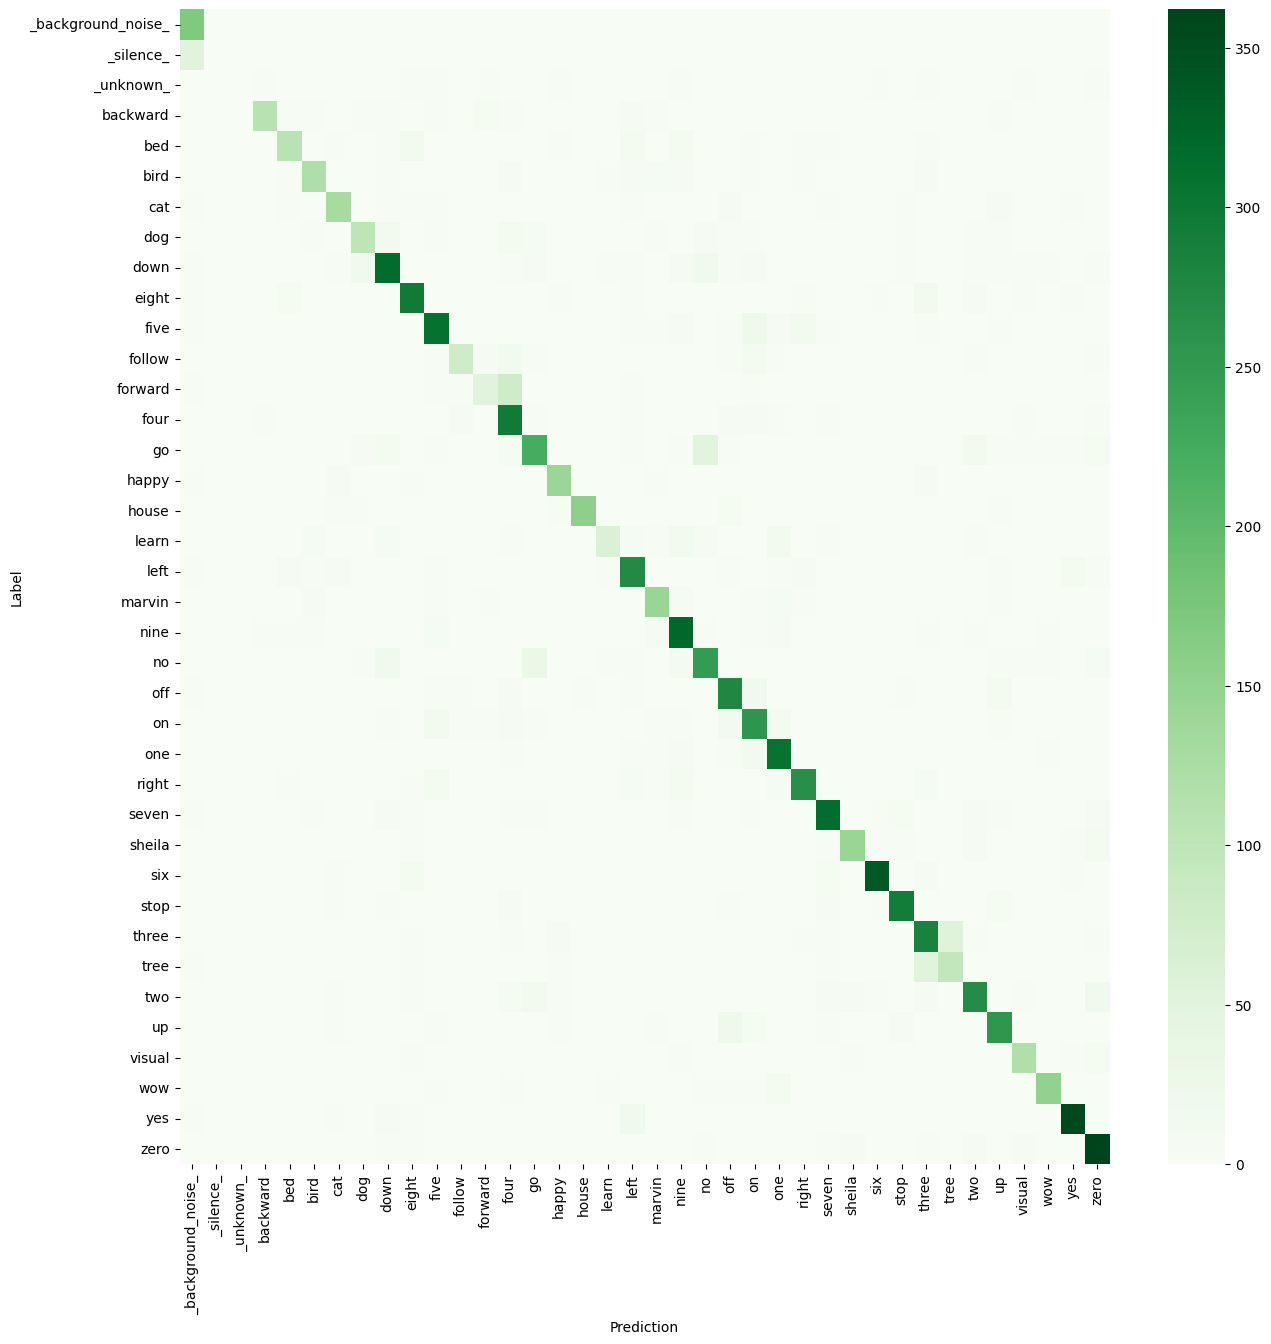

In [118]:
plot_confusion_matrix(model, x_test, y_test, labels=target_list)

In [119]:
# Save the model as a file
models.save_model(model, model_filename)

In [120]:
# Load back the model and run it against test set

model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', np.argmax(model.predict(np.expand_dims(x_test[i], 0))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Answer: 36.0  Prediction: 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Answer: 30.0  Prediction: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 9.0  Prediction: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Answer: 19.0  Prediction: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 11.0  Prediction: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 20.0  Prediction: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 12.0  Prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 23.0  Prediction: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Answer: 20.0  Prediction: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 13.0  Prediction: 13


In [121]:
# Convert model to TF Lite model

# model = models.load_model(keras_model_filename)
models.load_model(model_filename)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# drops by 75% the final size of the model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

size = open(tflite_filename, 'wb').write(tflite_model)
print(f"The model is {size / 1024} KB")

INFO:tensorflow:Assets written to: /var/folders/33/wfzcrd1124s6rs_9s5m4j4yh0000gn/T/tmpf_iq1w_p/assets


INFO:tensorflow:Assets written to: /var/folders/33/wfzcrd1124s6rs_9s5m4j4yh0000gn/T/tmpf_iq1w_p/assets


Saved artifact at '/var/folders/33/wfzcrd1124s6rs_9s5m4j4yh0000gn/T/tmpf_iq1w_p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 28, 1), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  13312331024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13312329872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13312343504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6360652048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6360651472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6360651664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6360653584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6360652816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6360654736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6360653968: TensorSpec(shape=(), dtype=tf.resource, name=None)
The model is 51.078

W0000 00:00:1724185576.053509 21759460 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1724185576.053688 21759460 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-20 22:26:16.054980: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/33/wfzcrd1124s6rs_9s5m4j4yh0000gn/T/tmpf_iq1w_p
2024-08-20 22:26:16.055693: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-20 22:26:16.055707: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/33/wfzcrd1124s6rs_9s5m4j4yh0000gn/T/tmpf_iq1w_p
2024-08-20 22:26:16.062429: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-20 22:26:16.104345: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/33/wfzcrd1124s6rs_9s5m4j4yh0000gn/T/tmpf_iq1w_p
2024-08-20 22:26:16.115120: I tensorflow/cc/saved_model/loader.c

In [123]:
def test_quantized_model(
    model_path: str,
    start_idx: int,
    end_idx: int,
):
    """Loads and test the tflite model on the given indexes.
    
    Args:
      model_path: the path to the TFLite model
      start_idx: starting index to take the samples from x_test
      end_idx: ending index for x_test

    Returns:
      None
    """

    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test the model
    for i in range(start_idx, end_idx):
        # Load the input into the model
        input_data = np.array(np.expand_dims(x_test[i], 0), dtype=np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Invoke the model on the input
        interpreter.invoke()
        
        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        print(f'Ground truth value: {y_test[i]}\t\t'
              f'Prediction: {np.argmax(output_data)}')

In [124]:
print("Before quantization")
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', np.argmax(model.predict(np.expand_dims(x_test[i], 0))))

print("After quantization")
test_quantized_model(tflite_filename, 100, 110)

Before quantization
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Answer: 36.0  Prediction: 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Answer: 30.0  Prediction: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Answer: 9.0  Prediction: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 19.0  Prediction: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 11.0  Prediction: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Answer: 20.0  Prediction: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 12.0  Prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Answer: 23.0  Prediction: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Answer: 20.0  Prediction: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Answer: 13.0  Prediction: 13
After quantization
Ground truth value: 36.0		Prediction: 36
Ground truth value: 30.0		Prediction: 30
Ground truth value: 9.0		Prediction: 4
Ground truth value: 19.0		Prediction: 19
Ground truth value: 11.0		Prediction: 12
Ground truth value: 20.0		Prediction: 20
Ground truth value: 12.0		Prediction: 3
Ground tru

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Dump the TFLite model in a C file to see how much space it requires

In [ ]:
!apt-get update && apt-get -qq install xxd

zsh:1: command not found: apt-get


In [ ]:
!xxd -i /content/speech-commands-model.tflite > /content/embed_model.c

zsh:1: no such file or directory: /content/embed_model.c


In [ ]:
!du -h /content/embed_model.c

du: /content/embed_model.c: No such file or directory
